In [2]:
!unzip "/content/drive/MyDrive/data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: data/train/Premature Ventricular Contractions/fig_1532.png  
  inflating: data/train/Premature Ventricular Contractions/fig_1533.png  
  inflating: data/train/Premature Ventricular Contractions/fig_1534.png  
  inflating: data/train/Premature Ventricular Contractions/fig_1535.png  
  inflating: data/train/Premature Ventricular Contractions/fig_1536.png  
  inflating: data/train/Premature Ventricular Contractions/fig_1537.png  
  inflating: data/train/Premature Ventricular Contractions/fig_1538.png  
  inflating: data/train/Premature Ventricular Contractions/fig_1539.png  
  inflating: data/train/Premature Ventricular Contractions/fig_154.png  
  inflating: data/train/Premature Ventricular Contractions/fig_1540.png  
  inflating: data/train/Premature Ventricular Contractions/fig_1541.png  
  inflating: data/train/Premature Ventricular Contractions/fig_1542.png  
  inflating: data/train/Premature Ventricular Contractions/fig

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import logging


In [4]:
%matplotlib inline

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [5]:
def create_cnn_dataset(directory, target_size, batch_size):
    """Create dataset for CNN without feature extraction"""
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        fill_mode='nearest'
    )

    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    return generator

In [6]:
def create_validation_dataset(directory, target_size, batch_size):
    """Create validation dataset without augmentation"""
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return generator

In [7]:
train_dir = '/content/data/train'
test_dir = '/content/data/test'
target_size = (128, 128)  # Increased size for better feature extraction
batch_size = 32

# Create data generators
logger.info("Creating training dataset...")
train_generator = create_cnn_dataset(train_dir, target_size, batch_size)

logger.info("Creating validation dataset...")
test_generator = create_validation_dataset(test_dir, target_size, batch_size)

logger.info(f"Number of training samples: {train_generator.samples}")
logger.info(f"Number of test samples: {test_generator.samples}")
logger.info(f"Number of classes: {train_generator.num_classes}")
logger.info(f"Class indices: {train_generator.class_indices}")

Found 15341 images belonging to 6 classes.
Found 6825 images belonging to 6 classes.


In [8]:
def build_custom_cnn(input_shape, num_classes):
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Fifth Convolutional Block
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        GlobalAveragePooling2D(),  # Better than Flatten for reducing overfitting

        # Fully Connected Layers
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),

        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    return model


In [9]:
input_shape = (128, 128, 3)
num_classes = train_generator.num_classes

model = build_custom_cnn(input_shape, num_classes)
model.summary()

# Compile the model with optimized parameters
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,146,918 (19.63 MB)

 Trainable params: 5,143,398 (19.62 MB)

 Non-trainable params: 3,520 (13.75 KB)

In [10]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# Calculate steps per epoch
steps_per_epoch = train_generator.samples // batch_size
validation_steps = test_generator.samples // batch_size

# Train the model
logger.info("Training model...")
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps,
    epochs=50,  # Increased epochs with early stopping
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 117s 196ms/step - accuracy: 0.5669 - loss: 1.3535 - precision: 0.6482 - recall: 0.4845 - val_accuracy: 0.2413 - val_loss: 9.0220 - val_precision: 0.2413 - val_recall: 0.2413 - learning_rate: 0.0010
Epoch 2/50
  1/479 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - accuracy: 0.8125 - loss: 0.4494 - precision: 0.8621 - recall: 0.7812

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


479/479 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8125 - loss: 0.4494 - precision: 0.8621 - recall: 0.7812 - val_accuracy: 0.2413 - val_loss: 8.7850 - val_precision: 0.2413 - val_recall: 0.2413 - learning_rate: 0.0010
Epoch 3/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 80s 167ms/step - accuracy: 0.7965 - loss: 0.6042 - precision: 0.8553 - recall: 0.7468 - val_accuracy: 0.2413 - val_loss: 24.4230 - val_precision: 0.2413 - val_recall: 0.2413 - learning_rate: 0.0010
Epoch 4/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9688 - loss: 0.2661 - precision: 0.9655 - recall: 0.8750 - val_accuracy: 0.2413 - val_loss: 24.5537 - val_precision: 0.2413 - val_recall: 0.2413 - learning_rate: 0.0010
Epoch 5/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 137s 168ms/step - accuracy: 0.8583 - loss: 0.4124 - precision: 0.8981 - recall: 0.8236 - val_accuracy: 0.4911 - val_loss: 1.7476 - val_precision: 0.5162 - val_recall: 0.4459 - learning_rate: 0.0010
Epoch 6/50
479/479 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy:

In [11]:
model.save('my_ECG_CNN.h5')
logger.info("Model saved as 'my_ECG_CNN.h5'")

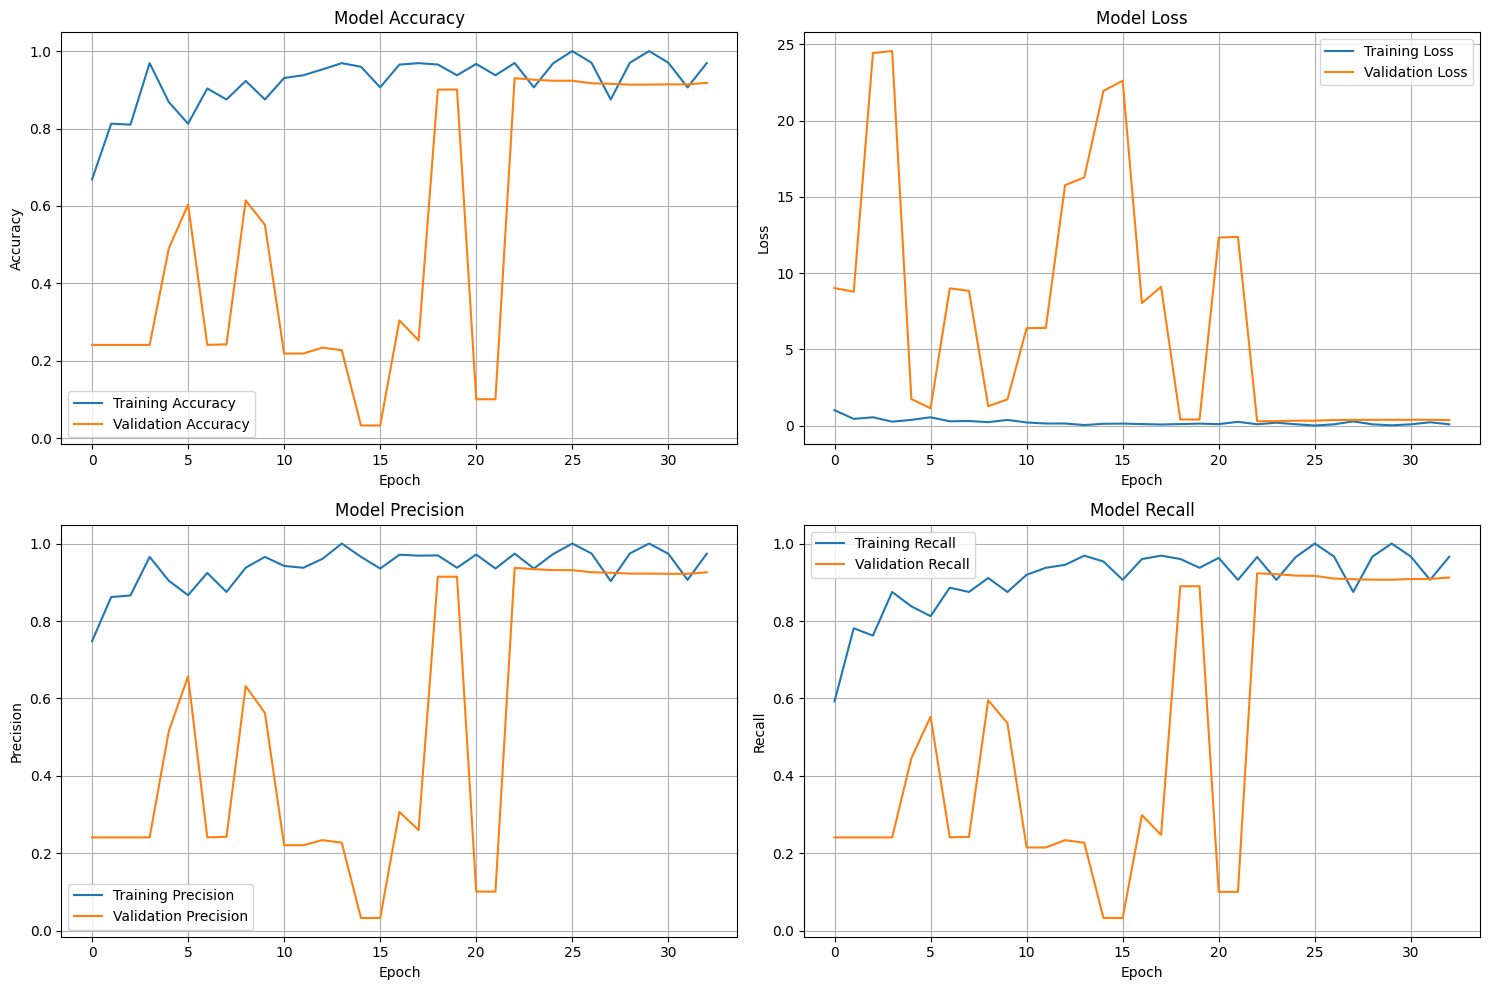

In [13]:
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Plot loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Plot precision
    axes[1, 0].plot(history.history['precision'], label='Training Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Plot recall
    axes[1, 1].plot(history.history['recall'], label='Training Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

In [12]:
logger.info("Evaluating model...")
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator, verbose=1)

print(f"\nFinal Test Results:")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Loss: {test_loss:.4f}")

214/214 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9427 - loss: 0.2258 - precision: 0.9488 - recall: 0.9373

Final Test Results:
Test Accuracy: 0.9301 (93.01%)
Test Precision: 0.9375
Test Recall: 0.9232
Test Loss: 0.2959


In [14]:
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"F1 Score: {f1_score:.4f}")

if test_accuracy > 0.95:
    print(f"\n🎉 SUCCESS! Achieved {test_accuracy*100:.2f}% accuracy (>95% target met!)")
else:
    print(f"\n📈 Current accuracy: {test_accuracy*100:.2f}%. Consider:")
    print("- Increasing training data")
    print("- Fine-tuning hyperparameters")
    print("- Adding more data augmentation")
    print("- Training for more epochs")

F1 Score: 0.9303

📈 Current accuracy: 93.01%. Consider:
- Increasing training data
- Fine-tuning hyperparameters
- Adding more data augmentation
- Training for more epochs
